In [1]:
from Bio import SeqIO, Seq
from Bio.Seq import CodonTable
from Bio.Seq import Seq
from Bio.Data.CodonTable import TranslationError
import pandas as pd
import numpy as np
from itertools import combinations, product, izip, permutations
import json
import pickle

from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from matplotlib import patches
import seaborn as sns
%matplotlib inline

In [2]:
all_muts = {l.split('\t')[0]: float(l.split('\t')[1]) for l in open('../titer_model/titered_output/antigenic_mutations.tsv')}
antigenic_mutations = {k:v for k,v in all_muts.items() if len(k.split(','))==1}
antigenic_clusters = {tuple(k.split(',')) : v for k,v in all_muts.items() if len(k.split(',')) > 1}

seqs = {s.name : s for s in SeqIO.parse(open('../data/sequences/titered_strains_alignment.mfa', 'r'), 'fasta')}
aa_aln = {k: Seq.translate(Seq(str(v.seq).replace('-', 'N'))) for k,v in seqs.items()}

colors = pickle.load(open('./colors.p', 'rb'))

In [3]:
def get_mutations(serum_seq, virus_seq):
    '''
    loops over all translations (listed in self.proteins) and returns a list of
    between as tuples (protein, mutation) e.g. (HA1, 159F)
    '''
    muts = ['E:'+aa1+str(pos+1)+aa2 for pos, (aa1, aa2)
                in enumerate(izip(serum_seq, virus_seq)) if aa1!=aa2]
    return muts

def get_antigenic_mutations(serum_seq, virus_seq, antigenic_mutations, antigenic_clusters):
    
    observed_antigenic_mutations = []
    observed_mutations = get_mutations(serum_seq, virus_seq)
    
    for m in antigenic_mutations.keys():
        if m in observed_mutations:
            observed_antigenic_mutations.append(m)
            
    for cl in antigenic_clusters.keys():
        if any([m in observed_mutations for m in cl]):
            observed_antigenic_mutations.append(cl)
    
    return observed_antigenic_mutations

def annotate_mutation(mut, antigenic_mutations, antigenic_clusters):
    
    if type(mut) == tuple:
        size = len(mut)
        db = antigenic_clusters[mut]
        mut = ','.join(mut)

    else:
        size = 1
        db = antigenic_mutations[mut]
        
    return {'size': size, 'db': db, 'mut': mut}

def compare_strains(serum, virus, aa_aln, antigenic_mutations, antigenic_clusters):
    
    serum_sero = serum.split('/')[0]
    virus_sero = virus.split('/')[0]
    
    serum_seq = aa_aln[serum]
    virus_seq = aa_aln[virus]
    
    observed_antigenic_mutations = get_antigenic_mutations(serum_seq, virus_seq, antigenic_mutations, antigenic_clusters)
    observed_antigenic_mutations = [annotate_mutation(mut, antigenic_mutations, antigenic_clusters) for mut in observed_antigenic_mutations]
    for mut in observed_antigenic_mutations:
        mut.update({'serum_serotype': serum_serotype, 'virus_serotype': virus_serotype})
    return observed_antigenic_mutations

n_pairs = defaultdict(float)
all_observed_antigenic_mutations = []
pairwise_muts = {}

for serum in aa_aln.keys():
    serum_serotype = serum.split('/')[0]
    
    for virus in aa_aln.keys():
        muts = compare_strains(serum, virus, aa_aln, antigenic_mutations, antigenic_clusters)
        all_observed_antigenic_mutations += muts
        pairwise_muts[(serum,virus)] = muts
        virus_serotype = virus.split('/')[0]
        
        if serum_serotype == virus_serotype:
            n_pairs[serum_serotype] += 1
        else:
            n_pairs['Interserotype'] += 1

n_pairs = dict(n_pairs)

In [4]:
antigenic_df = pd.DataFrame(all_observed_antigenic_mutations)


In [5]:
antigenic_df = pd.DataFrame(all_observed_antigenic_mutations)

categories = []
for (s1,s2) in zip(antigenic_df['serum_serotype'], antigenic_df['virus_serotype']):
    if s1 == s2:
        categories.append(s1)
    else:
        categories.append('Interserotype')
        
antigenic_df['category'] = categories
antigenic_df = antigenic_df.drop(['serum_serotype', 'virus_serotype'], axis=1)
antigenic_counts = antigenic_df.groupby(['mut', 'category', 'db', 'size']).size().reset_index(name='count')

In [12]:
antigenic_counts_latex = antigenic_counts.drop(['size', 'category', 'count'], axis=1)
antigenic_counts_latex.rename(columns={'mut': 'Mutation', 'db': '$d_m$'}, inplace=True)
antigenic_counts_latex = antigenic_counts_latex.drop_duplicates(['Mutation'])
antigenic_counts_latex['Mutation'] = antigenic_counts_latex['Mutation'].map(lambda s: s.replace('E:', ''))

antigenic_counts_latex['sort_key'] = antigenic_counts_latex['Mutation'].map(lambda s: int(s.split(',')[0][1:-1]))
antigenic_counts_latex.sort_values(['sort_key', '$d_m$'], inplace=True)
antigenic_counts_latex.drop('sort_key', inplace=True, axis=1)
latex = antigenic_counts_latex.to_latex(index=False)
antigenic_counts_latex.to_csv('./attachments/antigenic_mutations.csv')
print(latex)

\begin{tabular}{lr}
\toprule
                        Mutation &  \$d\_m\$ \\
\midrule
 I6V,S29G,F90Y,T176P,V197I,L475M &   0.71 \\
                            A19T &   0.02 \\
                            N83K &   0.34 \\
                            A88K &   0.08 \\
                            A88Q &   1.39 \\
                            Y90F &   0.43 \\
                            V91I &   0.35 \\
                            K93R &   0.20 \\
                           V114I &   0.90 \\
                           L122S &   0.03 \\
                           S122L &   0.07 \\
                           N124K &   0.10 \\
                           V129I &   0.01 \\
                           I129V &   0.21 \\
                           I129A &   0.23 \\
                           Y132I &   0.12 \\
                     Y132P,R233Q &   0.34 \\
                           I139V &   0.05 \\
                           D154E &   0.03 \\
                           K160V &   0.03 \\
              

In [13]:
domains = {
    (1,51): 'I',
    (52,131): 'I I',
    (132,192): 'I',
    (193,279): 'I I',
    (280,295): 'I',
    (296,394): 'I I I',
    (394,495): 'Transmembrane'
}

xticks = [1,52,132,193,280,296,394,495]
    
def plot_E_domains(ax, domains=domains):
    
    c1 = 'lightgray'
    c2 = 'gray'
    
    relative_loc = { (float(k[0])/495., float(k[1])/495.) : v for k,v in domains.items()}
    
    for i, ((start,end), domain) in enumerate(sorted(relative_loc.items())):
        w = end - start
        h = 1
        if i%2 == 0:
            c = c1
        else:
            c = c2
            
        p = patches.Rectangle(xy=(start,0), width=w, height=h, color=c, transform = ax.transAxes)
        ax.add_patch(p)
        label = ax.text(start+w/2., 0.5, domain, transform = ax.transAxes, ha='center', va='center', fontsize=12)
        
    ax.set_xticklabels(xticks)
    ax.set_xticks([float(x)/395. for x in xticks])
    ax.set_yticks([])

In [22]:
def plot_position_db(all_counts, category, ax, c):

    plt.sca(ax)
    vmin=0.
    vmax=0.4    
    if category == 'Interserotype':
        interserotype = all_counts.loc[all_counts['category'] == 'Interserotype']
        ymax = interserotype['db'].max()
    else:
        within_serotype = all_counts.loc[all_counts['category'] != 'Interserotype']
        ymax = within_serotype['db'].max()
    
    counts = all_counts.loc[all_counts['category'] == category]
    
    singleton_counts = counts.loc[counts['mut'].str.count(',')==0]
    singleton_counts['position'] = singleton_counts['mut'].str[3:-1].astype(int)
    ax.scatter(singleton_counts['position'], singleton_counts['db'], s=singleton_counts['size']*100., 
               c=c, alpha=0.6, edgecolors="grey", linewidth=2, marker='o')

    
    cluster_counts = counts.loc[counts['mut'].str.count(',')>0]

    for idx, cluster in cluster_counts.iterrows():
        cl_x= [int(m[3:-1]) for m in cluster['mut'].split(',')]
        cl_y= [cluster['db']]*len(cl_x)

        ax.scatter(cl_x, cl_y, s=cluster['size']*100., c=c, 
                  alpha=0.5, edgecolors="darkgrey", linewidth=2, marker='o', zorder=len(counts)+1)    
        ax.plot(cl_x, cl_y, '--', c='darkgray', zorder=len(counts)+2)
    
    ax.set_xlim(0,495)
    ax.set_xticks(xticks)       
    ticklabels = ax.get_xticklabels()
    ticklabels[4].set_ha("right")
    ticklabels[5].set_ha("left")
    
    ax.set_ylim(0, 2.5)    
    ax.set_xlabel('Amino acid position in E')
    if category != 'DENV2' and category != 'DENV4':
        ax.set_ylabel(r'$Log_2(titers)$')
    else:
        ax.set_ylabel('')
    ax.set_title(category)

serotype_colormaps = {
    'Interserotype': plt.cm.Greys,
    'DENV1': plt.cm.Blues,
    'DENV2': plt.cm.Greens,
    'DENV3': plt.cm.Purples,
    'DENV4': plt.cm.Reds
}

sns.set(style='whitegrid', font_scale=1.2)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


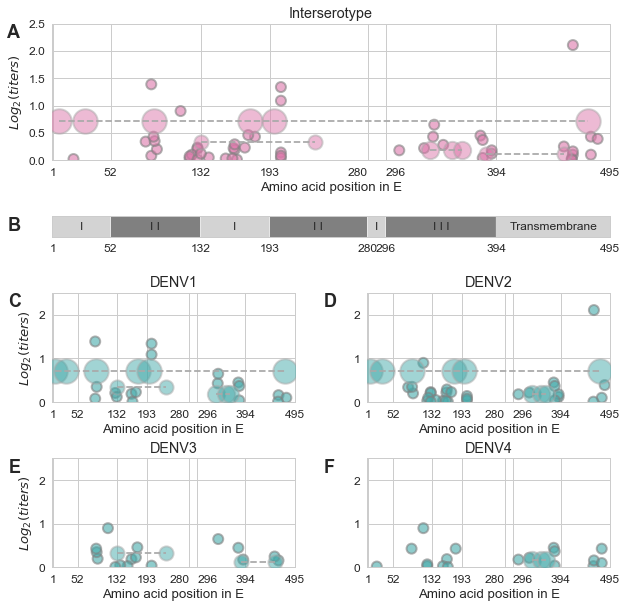

In [23]:
def add_subfigure_label(ax, label, x=-0.18, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(nrows=4, ncols=2,
                       width_ratios=[1,1], height_ratios=[1,.15,.8,.8], 
                       hspace=0.6, wspace=0.3)

ax0 = plt.subplot(gs[0,:])
plot_position_db(antigenic_counts, 'Interserotype', ax0, colors['interserotype_effects'])
add_subfigure_label(ax0, 'A', x=-.08)

ax1 = plt.subplot(gs[2,0])
plot_position_db(antigenic_counts, 'DENV1', ax1, colors['all_effects'])
add_subfigure_label(ax1, 'C')

ax2 = plt.subplot(gs[2,1])
plot_position_db(antigenic_counts, 'DENV2', ax2, colors['all_effects'])
add_subfigure_label(ax2, 'D')

ax3 = plt.subplot(gs[3,0])
plot_position_db(antigenic_counts, 'DENV3', ax3, colors['all_effects'])
add_subfigure_label(ax3, 'E')

ax4 = plt.subplot(gs[3,1])
plot_position_db(antigenic_counts, 'DENV4', ax4, colors['all_effects'])
add_subfigure_label(ax4, 'F')

gene_ax = plt.subplot(gs[1,:])
plot_E_domains(gene_ax)
add_subfigure_label(gene_ax, 'B',x=-.08)

plt.savefig('./png/mutations_position_db.png', dpi=300, bbox_inches='tight')

In [18]:
def plot_counts_db(counts, ax, c):
    plt.sca(ax)
    
    ax.scatter(counts['db'], counts['count'], s=counts['size']*100., 
               c=c, alpha=0.6, edgecolors="grey", linewidth=2, marker='o')
    
    ax.set_ylabel('N observations')
    ax.set_xlabel(r'$Log_2(titers)$')
    ax.set_xlim(0,2.5)
#     ax.set_ylim(0,0.45)

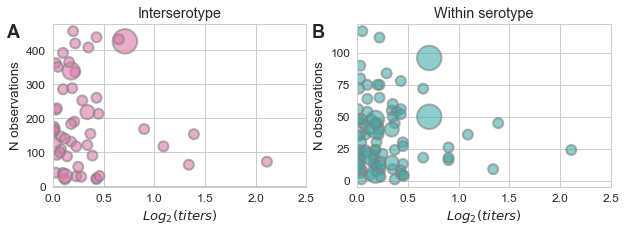

In [19]:
sns.set(style='whitegrid', font_scale=1.2)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

within_serotype = antigenic_counts.loc[antigenic_counts['category']!='Interserotype']
between_serotypes = antigenic_counts.loc[antigenic_counts['category'] == 'Interserotype']

plot_counts_db(between_serotypes, axes[0], colors['interserotype_effects'])
axes[0].set_title('Interserotype')
add_subfigure_label(axes[0], 'A')
plot_counts_db(within_serotype, axes[1], colors['all_effects'])
axes[1].set_title('Within serotype')
add_subfigure_label(axes[1], 'B')
plt.savefig('./png/mutations_db_N.png', dpi=300, bbox_inches='tight')

In [28]:
antigenic_counts.head()

,mut,category,db,size,count,frequency
0,E:A162I,DENV1,0.19,1,30,0.300000
1,E:A162I,DENV3,0.19,1,7,0.086420
2,E:A162I,DENV4,0.19,1,11,0.065089
3,E:A162I,Interserotype,0.19,1,288,0.169611
4,E:A19T,DENV4,0.02,1,72,0.426036
